## Google Analytics Reporting API

This script requests a report from Google Analytics Reporting API and returns the response as a dataframe. It can handle pivot reports, summary reports with no pivot, and simple reports with no dimensions.

To establish proper credentials, you need to:

1. Create a project on Google Cloud Platform
2. Enable Google Analytics Reporting API for this project
3. Create a service account associated with the project
4. Generate API keys for the service account
5. In GA Admin panel, give your service account (looks like an email address) read access to your site's GA data.


Links:

Creating projects: https://cloud.google.com/resource-manager/docs/creating-managing-projects
Creating service account keys: https://cloud.google.com/iam/docs/creating-managing-service-account-keys
Metrics and dimensions: https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/ 

In [1]:
import numpy as np
import pandas as pd
from google.oauth2 import service_account
from apiclient.discovery import build

In [2]:
def format_summary(response):
    try:
        # create row index
        try: 
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except:
            row_index_named = None
        
        # extract column names
        summary_column_names = [item['name'] for item in response['reports'][0]
                                ['columnHeader']['metricHeader']['metricHeaderEntries']]
    
        # extract table values
        summary_values = [element['metrics'][0]['values'] for element in response['reports'][0]['data']['rows']]
    
        # combine. I used type 'float' because default is object, and as far as I know, all values are numeric
        df = pd.DataFrame(data = np.array(summary_values), 
                          index = row_index_named, 
                          columns = summary_column_names).astype('float')
    
    except:
        df = pd.DataFrame()
        
    return df

def format_pivot(response):
    try:
        # extract table values
        pivot_values = [item['metrics'][0]['pivotValueRegions'][0]['values'] for item in response['reports'][0]
                        ['data']['rows']]
        
        # create column index
        top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        array = np.concatenate((np.array(top_header),
                                np.array(column_metrics).reshape((len(column_metrics),1))), 
                               axis = 1)
        column_index = pd.MultiIndex.from_arrays(np.transpose(array))
        
        # create row index
        try:
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except: 
            row_index_named = None
        # combine into a dataframe
        df = pd.DataFrame(data = np.array(pivot_values), 
                          index = row_index_named, 
                          columns = column_index).astype('float')
    except:
        df = pd.DataFrame()
    return df

def format_report(response):
    summary = format_summary(response)
    pivot = format_pivot(response)
    if pivot.columns.nlevels == 2:
        summary.columns = [['']*len(summary.columns), summary.columns]
    
    return(pd.concat([summary, pivot], axis = 1))

def run_report(body, credentials_file):
    #Create service credentials
    credentials = service_account.Credentials.from_service_account_file(credentials_file, 
                                scopes = ['https://www.googleapis.com/auth/analytics.readonly'])
    #Create a service object
    service = build('analyticsreporting', 'v4', credentials=credentials)
    
    #Get GA data
    response = service.reports().batchGet(body=body).execute()
    
    return(format_report(response))

The report request is in dictionary/JSON format, and can have a Summary and Pivot section. The request must have a date range and metrics. View ID is the number in GA that identifies your site and the data view associated with it (immediately to the right of the Analytics logo on the top right in GA).   

Credentials is the link to your service account key JSON file.

Reference:
Basics of creating reports: https://developers.google.com/analytics/devguides/reporting/core/v4/basics
Dimensions and metrics: https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/ 

In [3]:
your_view_id = '00000000'
ga_keys = 'api_keys.json'

In [5]:
body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-04-30'}],
                            'metrics': [{'expression': 'ga:users'}, 
                                        {"expression": "ga:bounceRate"}],
                            'dimensions': [{'name': 'ga:yearMonth'}],
                            "pivots": [{"dimensions": [{"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:bounceRate"}]
                                       }]
                          }]}

In [6]:
summary_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            'metrics': [{'expression': 'ga:sessions'}, 
                                        {'expression': 'ga:totalEvents'}, 
                                        {"expression": "ga:avgSessionDuration"}],
                            'dimensions': [{'name': 'ga:country'}],
                          }]}

In [7]:
pivot_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            'dimensions': [{'name':  "ga:channelGrouping"}],
                            "pivots": [{"dimensions": [{"name": 'ga:yearMonth'}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:newUsers"},
                                                    {"expression": "ga:timeOnPage"}]
                                       }]
                          }]}

In [8]:
short_body = {  "reportRequests":
  [{
      "viewId": your_view_id,
      "dateRanges": [{"startDate": "7daysAgo", "endDate": "yesterday"}],
      "metrics": [{"expression": "ga:users"}]
    }]}

In [9]:
untidy_body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-02-28'}],
                            "pivots": [{"dimensions": [{"name": 'ga:yearMonth'}, {"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:timeOnPage"}]
                                       }]
                          }]}

Example of an output

In [10]:
ga_report = run_report(body, ga_keys)
ga_report

Organic Search                 Direct  \
             ga:users ga:bounceRate       ga:users ga:bounceRate ga:users   
ga:yearMonth                                                                
202101          317.0     73.972603          195.0     78.205128     78.0   
202102          311.0     82.159624          254.0     85.585586     46.0   
202103          460.0     86.446886          383.0     87.772926     69.0   
202104          532.0     84.671533          411.0     87.927565    103.0   

                             Social               Referral                
             ga:bounceRate ga:users ga:bounceRate ga:users ga:bounceRate  
ga:yearMonth                                                              
202101           77.235772     42.0     58.904110      2.0     37.500000  
202102           82.089552      6.0     33.333333      5.0     60.000000  
202103           86.486486      3.0     22.222222      5.0     80.000000  
202104           85.333333      9.0     28.571429      9.0     52.941176

### Code Explanation

This section shows what the response looks like on the inside, and how the code gets to the data. This is for demonstration only. 

In [11]:
credentials = service_account.Credentials.from_service_account_file(ga_keys, 
                                scopes = ['https://www.googleapis.com/auth/analytics.readonly'])
    #Create a service object
service = build('analyticsreporting', 'v4', credentials=credentials)
    
    #Get GA data
response = service.reports().batchGet(body=body).execute()
response

{'reports': [{'columnHeader': {'dimensions': ['ga:yearMonth'],
    'metricHeader': {'metricHeaderEntries': [{'name': 'ga:users',
       'type': 'INTEGER'},
      {'name': 'ga:bounceRate', 'type': 'PERCENT'}],
     'pivotHeaders': [{'pivotHeaderEntries': [{'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Organic Search'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Organic Search'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:users', 'type': 'INTEGER'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Direct'],
         'metric': {'name': 'ga:bounceRate', 'type': 'PERCENT'}},
        {'dimensionNames': ['ga:channelGrouping'],
         'dimensionValues': ['Social'],
         'metric': {'name': 

In [12]:
format_pivot(response)

Organic Search                 Direct                 Social  \
                   ga:users ga:bounceRate ga:users ga:bounceRate ga:users   
ga:yearMonth                                                                
202101                195.0     78.205128     78.0     77.235772     42.0   
202102                254.0     85.585586     46.0     82.089552      6.0   
202103                383.0     87.772926     69.0     86.486486      3.0   
202104                411.0     87.927565    103.0     85.333333      9.0   

                           Referral                
             ga:bounceRate ga:users ga:bounceRate  
ga:yearMonth                                       
202101           58.904110      2.0     37.500000  
202102           33.333333      5.0     60.000000  
202103           22.222222      5.0     80.000000  
202104           28.571429      9.0     52.941176

In [13]:
top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
array = np.concatenate((np.array(top_header),
                        np.array(column_metrics).reshape((len(column_metrics),1))),
                       axis = 1)
column_index = pd.MultiIndex.from_arrays(np.transpose(array))
column_index

MultiIndex([('Organic Search',      'ga:users'),
            ('Organic Search', 'ga:bounceRate'),
            (        'Direct',      'ga:users'),
            (        'Direct', 'ga:bounceRate'),
            (        'Social',      'ga:users'),
            (        'Social', 'ga:bounceRate'),
            (      'Referral',      'ga:users'),
            (      'Referral', 'ga:bounceRate')],
           )

In [14]:
[item.get('dimensionValues') for item in response['reports'][0]['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]

[['Organic Search'],
 ['Organic Search'],
 ['Direct'],
 ['Direct'],
 ['Social'],
 ['Social'],
 ['Referral'],
 ['Referral']]

## Visualization Example No 1

In [23]:
body = body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-04-30'}],
                            'metrics': [{'expression': 'ga:users'}], 
                            'dimensions': [{'name': 'ga:yearMonth'}],
                            "pivots": [{"dimensions": [{"name": "ga:channelGrouping"}],
                                        "metrics": [{"expression": "ga:users"},
                                                    {"expression": "ga:bounceRate"}]
                                       }]
                          }]}

In [24]:
report = run_report(body, ga_keys)
report

Organic Search                 Direct                \
             ga:users       ga:users ga:bounceRate ga:users ga:bounceRate   
ga:yearMonth                                                                
202101          317.0          195.0     78.205128     78.0     77.235772   
202102          311.0          254.0     85.585586     46.0     82.089552   
202103          460.0          383.0     87.772926     69.0     86.486486   
202104          532.0          411.0     87.927565    103.0     85.333333   

               Social               Referral                
             ga:users ga:bounceRate ga:users ga:bounceRate  
ga:yearMonth                                                
202101           42.0     58.904110      2.0     37.500000  
202102            6.0     33.333333      5.0     60.000000  
202103            3.0     22.222222      5.0     80.000000  
202104            9.0     28.571429      9.0     52.941176

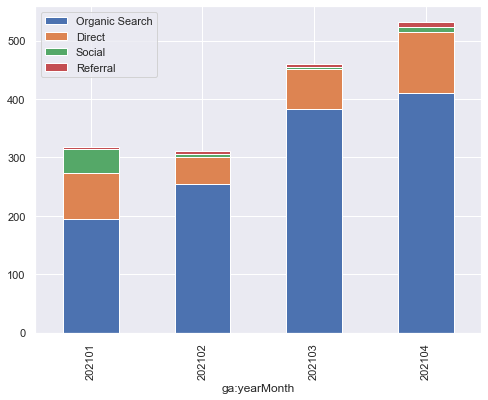

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style
sns.set_theme()
sns.set(rc={'figure.figsize':(8,6)})

plot_data = report.loc[:, (slice(None), "ga:users")].iloc[:, 1:] # Pick users columns, drop the first one (sum)
plot_data.columns = plot_data.columns.get_level_values(0)
plot_data.index = plot_data.index.get_level_values(0)
plot_data.plot.bar(stacked = True);

In [33]:
plot_data

,Organic Search,Direct,Social,Referral
ga:yearMonth,,,,
202101,195.0,78.0,42.0,2.0
202102,254.0,46.0,6.0,5.0
202103,383.0,69.0,3.0,5.0
202104,411.0,103.0,9.0,9.0


## Visualization Example No 2

In [34]:
body = body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2021-01-01', 'endDate': '2021-04-30'}],
                            'metrics': [{'expression': 'ga:sessions'},
                                        {"expression": "ga:avgSessionDuration"},
                                        {"expression": "ga:users"},
                                        {"expression": "ga:newUsers"}],
                            'dimensions': [{'name': 'ga:date'},
                                           {"name": "ga:channelGrouping"}],
                          }]}

report = run_report(body, ga_keys).reset_index() # index is turned into columns to help with visualization
report

,ga:date,ga:channelGrouping,ga:sessions,ga:avgSessionDuration,ga:users,ga:newUsers
0,20210101,Direct,2.0,20.000000,2.0,2.0
1,20210101,Organic Search,5.0,1074.400000,3.0,1.0
2,20210102,Direct,1.0,244.000000,1.0,1.0
3,20210102,Organic Search,3.0,1082.666667,3.0,1.0
4,20210103,Direct,2.0,37.500000,2.0,1.0
...,...,...,...,...,...,...
300,20210429,Organic Search,14.0,15.071429,13.0,8.0
301,20210429,Referral,1.0,0.000000,1.0,0.0
302,20210429,Social,1.0,0.000000,1.0,0.0
303,20210430,Direct,3.0,0.000000,3.0,2.0


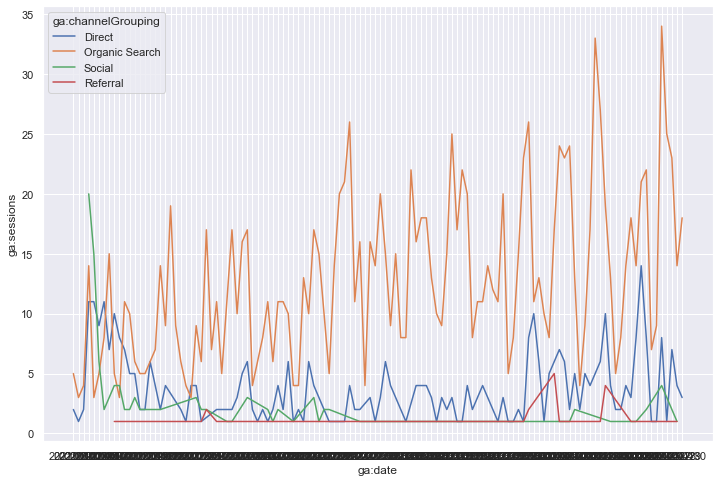

In [36]:
sns.set(rc={'figure.figsize':(12,8)})
plot_data = report.loc[:, ["ga:users"]]
sns.lineplot(data = report, y = "ga:sessions", x = 'ga:date', hue = 'ga:channelGrouping');